Epoch 1/10, Loss: 0.4286, Train Accuracy: 86.38%
Epoch 2/10, Loss: 0.2890, Train Accuracy: 91.00%
Epoch 3/10, Loss: 0.2694, Train Accuracy: 91.47%
Epoch 4/10, Loss: 0.2669, Train Accuracy: 91.81%
Epoch 5/10, Loss: 0.2472, Train Accuracy: 92.17%
Epoch 6/10, Loss: 0.1944, Train Accuracy: 93.71%
Epoch 7/10, Loss: 0.1834, Train Accuracy: 94.15%
Epoch 8/10, Loss: 0.1768, Train Accuracy: 94.28%
Epoch 9/10, Loss: 0.1747, Train Accuracy: 94.47%
Epoch 10/10, Loss: 0.1746, Train Accuracy: 94.42%
Epoch 11/10, Loss: 0.1692, Train Accuracy: 94.58%
Epoch 12/10, Loss: 0.1680, Train Accuracy: 94.62%
Epoch 13/10, Loss: 0.1671, Train Accuracy: 94.63%
Epoch 14/10, Loss: 0.1675, Train Accuracy: 94.65%
Epoch 15/10, Loss: 0.1707, Train Accuracy: 94.59%
Epoch 16/10, Loss: 0.1660, Train Accuracy: 94.62%
Epoch 17/10, Loss: 0.1702, Train Accuracy: 94.57%
Epoch 18/10, Loss: 0.1676, Train Accuracy: 94.74%
Epoch 19/10, Loss: 0.1678, Train Accuracy: 94.67%
Epoch 20/10, Loss: 0.1676, Train Accuracy: 94.77%
Epoch 21/

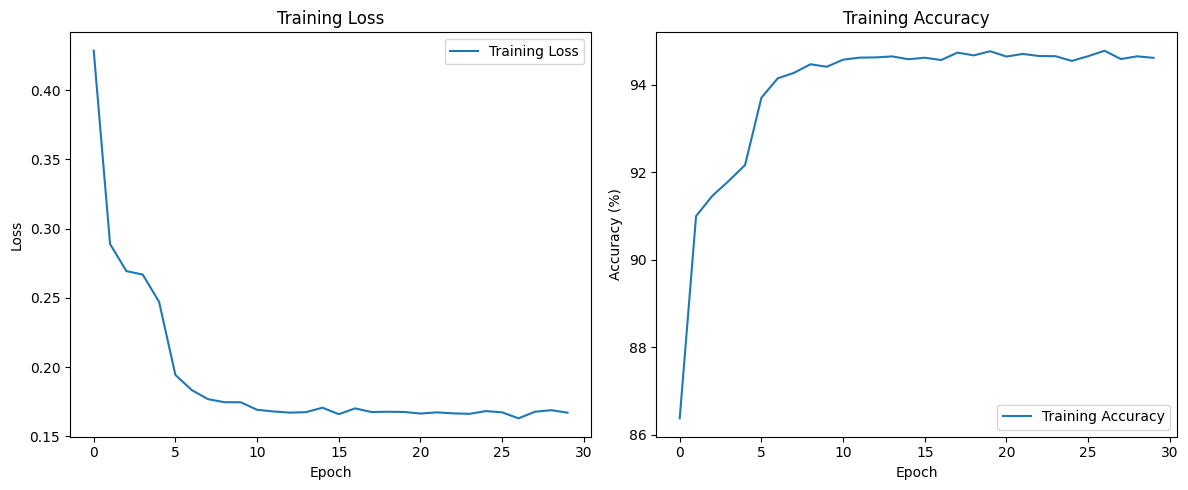

Extracting features...
Training KNN...
K=1, Accuracy: 94.92%
K=3, Accuracy: 95.84%
K=5, Accuracy: 96.18%
K=7, Accuracy: 96.27%
Optimal K=7, Final Accuracy with Simplified CNN + KNN: 96.27%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

class SimplifiedCNN(nn.Module):
    def __init__(self):
        super(SimplifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(10 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

# 数据预处理和增强
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST训练集和测试集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, (0.5,))
]))

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 设定设备，优先使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型、损失函数和优化器
model = SimplifiedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 训练模型的函数
def train_model():
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(30):
        running_loss = 0.0
        correct = 0
        total = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        train_accuracy = 100. * correct / total
        epoch_accuracies.append(train_accuracy)
        print(f'Epoch {epoch + 1}/10, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

train_model()

# 特征提取
print("Extracting features...")
model.eval()
train_features, train_labels = [], []
test_features, test_labels = [], []

with torch.no_grad():
    for data, target in train_loader:
        data = data.to(device)
        features = model(data).cpu().numpy()
        train_features.append(features)
        train_labels.extend(target.numpy())

    for data, target in test_loader:
        data = data.to(device)
        features = model(data).cpu().numpy()
        test_features.append(features)
        test_labels.extend(target.numpy())

train_features = np.concatenate(train_features, axis=0)
test_features = np.concatenate(test_features, axis=0)

# 训练和优化KNN
print("Training KNN...")
best_accuracy = 0
best_k = 0

for k in [1,3,5,7]:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(train_features, train_labels)
    predictions = knn.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions) * 100.0
    print(f"K={k}, Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
knn.fit(train_features, train_labels)
predictions = knn.predict(test_features)
final_accuracy = accuracy_score(test_labels, predictions) * 100.0

print(f"Optimal K={best_k}, Final Accuracy with Simplified CNN + KNN: {final_accuracy:.2f}%")

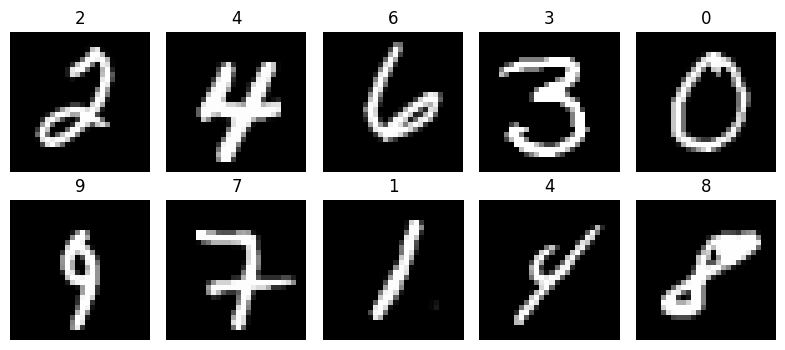

In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST训练集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 可视化MNIST数据集中的数字
def visualize_mnist_images(dataloader, num_images=10):
    plt.figure(figsize=(10, 4))  # 调整画布大小
    for i in range(num_images):
        data, target = next(iter(dataloader))
        img = data[i].squeeze()  # 移除批次维度
        img = img.numpy()  # 转换为numpy数组
        img = (img - img.min()) / (img.max() - img.min())  # 归一化到[0, 1]区间
        plt.subplot(2, 5, i+1)  # 2行5列
        plt.imshow(img, cmap='gray')  # 灰度图显示
        plt.title(f'{target[i]}', color='black', position=(0.5, -0.15), ha='center')  # 将标签移到图像下方
        plt.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.2)  # 调整子图间距
    plt.show()

# 调用函数，可视化10个MNIST图像
visualize_mnist_images(train_loader, num_images=10)